# Writting this to check the TS trend

In [10]:
import ee
import geemap
import numpy as np

Authenticate the GEE

In [6]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-vikramscience85')

Functions

In [11]:
# Function to mask pixels with low CS+ QA scores.
def maskLowQA(image):
    qaBand = 'cs'
    clearThreshold = 0.5
    mask = image.select(qaBand).gte(clearThreshold)
    return image.updateMask(mask)

# Function to add NDVI, time, and constant variables
def addVariables(image):
    #Compute time in fractional years since the epoch.
    date = image.date()
    years = date.difference(ee.Date('1970-01-01'), 'year')
    timeRadians = ee.Image(years.multiply(2 * np.pi))

  #Return the image with the added bands.
    ndvi = image.normalizedDifference(['B8', 'B4']).rename(['ndvi']);
    t = timeRadians.rename('t').float()
    constant = ee.Image.constant(1)
    return image.addBands([ndvi, t, constant])

In [29]:
# Initial date of interest (inclusive).
i_date = '2022-10-01'

# Final date of interest (exclusive).
f_date = '2025-05-01'

In [ ]:
# Define satellite Image collection.

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
filtered = s2\
           .filter(ee.Filter.date(i_date, f_date))

# Load the Cloud Score+ collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

# We need to add Cloud Score + bands to each Sentinel-2
# image in the collection
# This is done using the linkCollection() function
filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands)

filteredMasked = filteredS2WithCs\
    .map(maskLowQA)\
    .select('B.*')
filteredWithVariables = filteredMasked\
    .map(addNDVI)
ndvi = filteredWithVariables.select('ndvi')

In [23]:
# Define the locations -> LL.
# LL1
ll1_lon = 77.30310277777778
ll1_lat = 26.241936111111112
ll1_poi = ee.Geometry.Point(ll1_lon, ll1_lat)

# # LL2
# ll2_lon = 77.31343548943137
# ll2_lat = 26.235228705457775
# ll2_poi = ee.Geometry.Point(ll2_lon, ll2_lat)

# # LL3
# ll3_lon = 77.31343548943137
# ll3_lat = 26.235228705457775
# ll3_poi = ee.Geometry.Point(ll3_lon, ll3_lat)

# # LL3
# ll4_lon = 77.31343548943137
# ll4_lat = 26.235228705457775
# ll4_poi = ee.Geometry.Point(ll4_lon, ll4_lat)

In [31]:

Map = geemap.Map()
Map.addLayer(ll1_poi, {}, "LL1")
# Map.addLayer(ll2_poi, {}, "LL2")
# Map.addLayer(ll3_poi, {}, "LL3")
# Map.addLayer(ll4_poi, {}, "LL4")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [32]:
scale = 10
# Get the data for the pixel intersecting the point in urban area.
ndvi_ll1_poi = ndvi.getRegion(ll1_poi, scale).getInfo()
# ndvi_ll2_poi = ndvi.getRegion(ll2_poi, scale).getInfo()
# ndvi_ll3_poi = ndvi.getRegion(ll3_poi, scale).getInfo()
# ndvi_ll4_poi = ndvi.getRegion(ll4_poi, scale).getInfo()
# Preview the result.
ndvi_ll1_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'ndvi'],
 ['20221001T052651_20221001T053134_T43RGK',
  77.30312938621503,
  26.241900490048902,
  1664602899468,
  0.06330708661417322],
 ['20221006T052659_20221006T053723_T43RGK',
  77.30312938621503,
  26.241900490048902,
  1665034889602,
  None],
 ['20221011T052741_20221011T053331_T43RGK',
  77.30312938621503,
  26.241900490048902,
  1665466897823,
  None],
 ['20221016T052809_20221016T053343_T43RGK',
  77.30312938621503,
  26.241900490048902,
  1665898891460,
  0.09654036243822076]]

In [33]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [34]:
ndvi_df_ll1 = ee_array_to_df(ndvi_ll1_poi, ['ndvi'])
# ndvi_df_ll2 = ee_array_to_df(ndvi_ll2_poi, ['ndvi'])
# ndvi_df_ll3 = ee_array_to_df(ndvi_ll3_poi, ['ndvi'])
# ndvi_df_ll4 = ee_array_to_df(ndvi_ll4_poi, ['ndvi'])
ndvi_df_ll1.head()

,time,datetime,ndvi
0,1664602899468,2022-10-01 05:41:39.468,0.063307
3,1665898891460,2022-10-16 05:41:31.460,0.096540
4,1666330893820,2022-10-21 05:41:33.820,0.113137
5,1666762891409,2022-10-26 05:41:31.409,0.100994
6,1667194896097,2022-10-31 05:41:36.097,0.139692


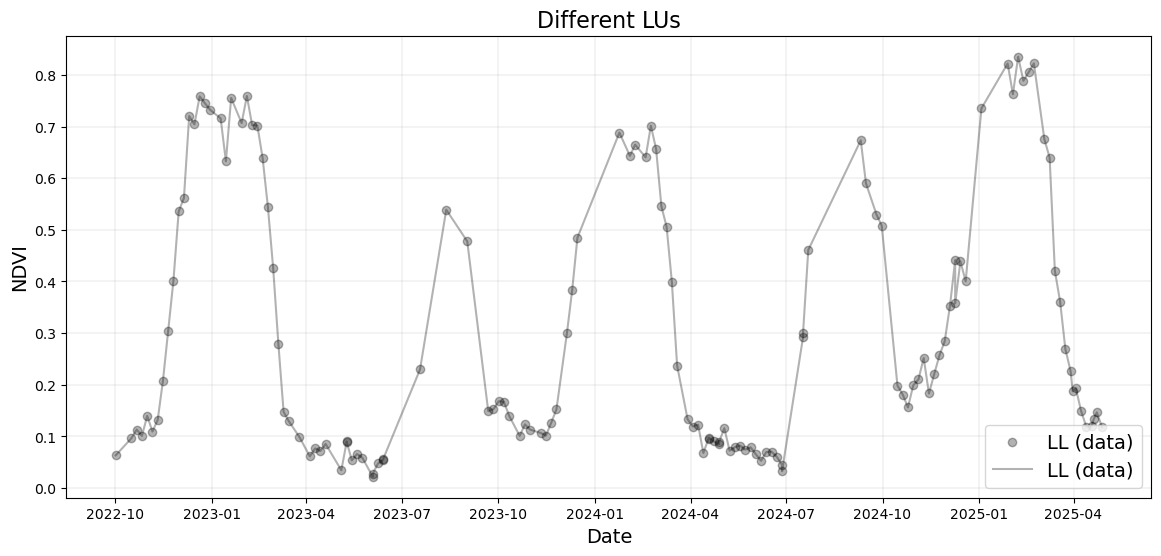

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# subplots
fig, ax = plt.subplots(figsize = (14,6))
ax.scatter(ndvi_df_ll1['datetime'], ndvi_df_ll1['ndvi'],
           c='black', alpha=0.3, label='LL (data)')
# ax.scatter(ndvi_df_ll2['datetime'], ndvi_df_ll2['ndvi'],
#            c='green', alpha=0.3, label='LL2 (data)')
# ax.scatter(ndvi_df_ll3['datetime'], ndvi_df_ll3['ndvi'],
#            c='orange', alpha=0.3, label='LL3 (data)')
# ax.scatter(ndvi_df_ll4['datetime'], ndvi_df_ll4['ndvi'],
#            c='red', alpha=0.3, label='LL4 (data)')

# Plot line
ax.plot(ndvi_df_ll1['datetime'], ndvi_df_ll1['ndvi'],
           c='black', alpha=0.3, label='LL (data)')
# ax.plot(ndvi_df_ll2['datetime'], ndvi_df_ll2['ndvi'],
#            c='green', alpha=0.3, label='LL2 (data)')
# ax.plot(ndvi_df_ll3['datetime'], ndvi_df_ll3['ndvi'],
#            c='orange', alpha=0.3, label='LL3 (data)')
# ax.plot(ndvi_df_ll4['datetime'], ndvi_df_ll4['ndvi'],
#            c='red', alpha=0.3, label='LL4 (data)')

# Fit curves.
# ## First, extract x values (times) from the dfs.
# x_data_ll1 = np.asanyarray(x_data_ll1['time'].apply(float))  # LL
# x_data_ll2 = np.asanyarray(x_data_ll2['time'].apply(float))  # LL2
# x_data_ll3 = np.asanyarray(x_data_ll3['time'].apply(float))  # LL3
# x_data_ll4 = np.asanyarray(x_data_ll4['time'].apply(float))  # LL4
## Secondly, extract y values (LST) from the dfs.
# y_data_ll = np.asanyarray(ndvi_df_ll['ndvi'].apply(float))  # LL
# y_data_bl = np.asanyarray(ndvi_df_bl['ndvi'].apply(float))  # BL
# y_data_cl = np.asanyarray(ndvi_df_cl['ndvi'].apply(float))  # CL

# ## Then, define the fitting function with parameters.
# def fit_func(t, lst0, delta_lst, tau, phi):
#     return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

# ## Optimize the parameters using a good start p0.
# lst0 = 0.4
# delta_lst = 0.6
# tau = 365*24*3600*1000   # milliseconds in a year
# phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

# params_ll, params_covariance_ll = optimize.curve_fit(
#     fit_func, x_data_ll, y_data_ll, p0=[lst0, delta_lst, tau, phi])
# params_bl, params_covariance_bl = optimize.curve_fit(
#     fit_func, x_data_bl, y_data_bl, p0=[lst0, delta_lst, tau, phi])
# params_cl, params_covariance_cl = optimize.curve_fit(
#     fit_func, x_data_cl, y_data_cl, p0=[lst0, delta_lst, tau, phi])

# # Add fitting curves.
# ax.plot(ndvi_df_ll['datetime'],
#         fit_func(x_data_ll, params_ll[0], params_ll[1], params_ll[2], params_ll[3]),
#         label='LL (fitted)', color='black', lw=2.5)
# ax.plot(ndvi_df_bl['datetime'],
#         fit_func(x_data_bl, params_bl[0], params_bl[1], params_bl[2], params_bl[3]),
#         label='BL (fitted)', color='green', lw=2.5)
# ax.plot(ndvi_df_cl['datetime'],
#         fit_func(x_data_cl, params_cl[0], params_cl[1], params_cl[2], params_cl[3]),
#         label='BL (fitted)', color='yellow', lw=2.5)

# Add some parameters.
ax.set_title('Different LUs', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('NDVI', fontsize=14)
#ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')
plt.show()